# (28) debug — why different from pvae?

**Motivation**: host = ```mach```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 1
device = f'cuda:{device_idx}'

## Init Iterative PVAE

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')

cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 1

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 3000
cfg_tr['batch_size'] = 1000
cfg_tr['kl_beta'] = 1.0

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'enc_type': 'lin', 'dec_type': 'lin', 'enc_bias': False, 
'dec_bias': False, 'init_dist': 'normal', 'init_scale': 0.01, 'seq_len': 1}

Trainer:
{'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 'kl_const_portion': 
0.0, 'lr': 0.002, 'kl_beta': 1.0}

### Make model + trainer

In [4]:
tr_ipvae = TrainerVAE(
    HIPVAE(CFG_CLASSES[model_type](**cfg_vae)),
    ConfigTrainVAE(**cfg_tr),
    device=device,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  262.7 K   |
|     ———     |    ———     |
|  layers.L_0 |  262.7 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-1_z-[512]_<lin|lin>
mc_b1000-ep3000-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_08_28,12:43)

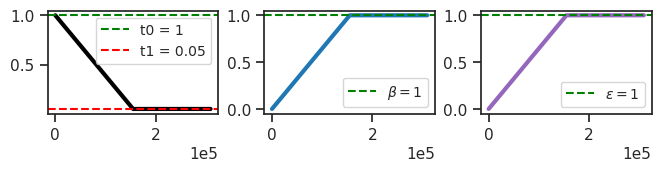

In [5]:
tr_ipvae.model.print()
print(f"{tr_ipvae.model.cfg.name()}\n{tr_ipvae.cfg.name()}_({tr_ipvae.model.timestamp})\n")
tr_ipvae.show_schedules()

In [6]:
print(vars(tr_ipvae.model.cfg))

{
    'prior_log_dist': 'uniform',
    'prior_clamp': -4,
    'hard_fwd': False,
    'exc_only': False,
    'type': 'poisson',
    'n_ch': 32,
    'seq_len': 1,
    'n_latents': [512],
    'lateral_ker_sz': [None],
    'enc_type': 'lin',
    'dec_type': 'lin',
    'enc_bias': False,
    'dec_bias': False,
    'enc_norm': False,
    'dec_norm': False,
    'dataset': 'vH16',
    'input_sz': 16,
    'fit_prior': True,
    'use_bn': False,
    'use_se': True,
    'res_eps': 1.0,
    'init_dist': 'normal',
    'init_scale': 0.01,
    'activation_fn': 'swish',
    'seed': 0,
    'base_dir': '/home/hadi/Projects/PoissonVAE',
    'data_dir': '/home/hadi/Datasets',
    'runs_dir': '/home/hadi/Projects/PoissonVAE/runs/poisson_uniform_c(-4)_vH16_t-1_z-[512]_<lin|lin>',
    'mods_dir': '/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-4)_vH16_t-1_z-[512]_<lin|lin>',
    'results_dir': '/home/hadi/Projects/PoissonVAE/results'
}

In [7]:
print(vars(tr_ipvae.cfg))

{
    'lr': 0.002,
    'epochs': 3000,
    'batch_size': 1000,
    'file_name': None,
    'warm_restart': 0,
    'warmup_epochs': 5,
    'optimizer': 'adamax_fast',
    'optimizer_kws': {'weight_decay': 0.0, 'betas': (0.9, 0.999), 'eps': 1e-08},
    'scheduler_type': 'cosine',
    'scheduler_kws': {'T_max': 2995.0, 'eta_min': 1e-05},
    'ema_rate': None,
    'grad_clip': 500,
    'chkpt_freq': 50,
    'eval_freq': 20,
    'log_freq': 10,
    'use_amp': False,
    'method': 'mc',
    'kl_beta': 1.0,
    'kl_beta_min': 0.0001,
    'kl_balancer': None,
    'kl_anneal_cycles': 0,
    'kl_anneal_portion': 0.5,
    'kl_const_portion': 0.0,
    'lambda_anneal': False,
    'lambda_init': 0.0,
    'lambda_norm': 0.0,
    'temp_anneal_portion': 0.5,
    'temp_anneal_type': 'lin',
    'temp_start': 1.0,
    'temp_stop': 0.05
}

In [8]:
self = tr_ipvae
x = next(iter(self.dl_vld))[0]

dist, kl, recon_batch = self._fun(x)
kl.shape, recon_batch.shape

(torch.Size([1000, 1, 512]), torch.Size([1000, 1]))

In [9]:
kl_batch = torch.sum(kl, dim=2)
kl_balanced = torch.mean(kl_batch, dim=1)

kl_batch.shape, kl_balanced.shape

(torch.Size([1000, 1]), torch.Size([1000]))

In [10]:
(kl_batch.ravel() - kl_balanced).abs().sum()

tensor(0., device='cuda:1', grad_fn=<SumBackward0>)

In [11]:
(recon_batch.ravel() - torch.mean(recon_batch, dim=1)).abs().sum()

tensor(0., device='cuda:1', grad_fn=<SumBackward0>)

In [12]:
recon_batch.mean(), kl_batch.mean()

(tensor(195.9985, device='cuda:1', grad_fn=<MeanBackward0>),
 tensor(0.0428, device='cuda:1', grad_fn=<MeanBackward0>))

In [13]:
loss_batch = (
    torch.mean(recon_batch, dim=1) +
    kl_balanced.mul(1.0)
)

In [14]:
loss = torch.mean(loss_batch)
loss

tensor(196.0414, device='cuda:1', grad_fn=<MeanBackward0>)

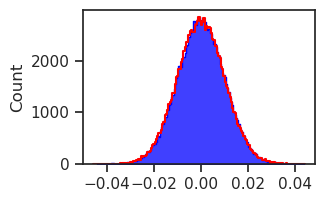

In [15]:
sns.histplot(tonp(self.model.input_layer.fc_dec.weight.data).ravel(), element='step', color='b')
sns.histplot(tonp(self.model.input_layer.fc_enc.weight.data).ravel(), element='step', fill=False, color='r');

In [16]:
self.model.input_layer

PoissonLayer(dim=512, input_dim=16, temp=1, eps=0, n_exp=263)

In [17]:
self.model.input_layer.temp

tensor(1., device='cuda:1')

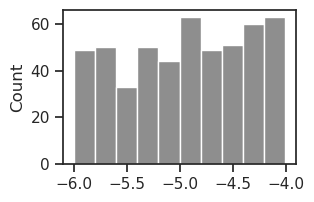

In [18]:
sns.histplot(tonp(self.model.input_layer.log_rate.ravel()), color='dimgrey');

In [19]:
x = next(iter(self.dl_vld))[0]

with torch.inference_mode():
    output = self.model(x)
    output = output.stack()

list(output)

['recon', 'dist', 'spks', 'ff', 'fb', 'loss_kl', 'loss_recon']

In [41]:
dist = output['dist']['T_0']['L_0']
dist.rate

tensor([[0.0090, 0.0052, 0.0022,  ..., 0.0206, 0.0093, 0.0073],
        [0.0070, 0.0033, 0.0024,  ..., 0.0174, 0.0062, 0.0061],
        [0.0097, 0.0049, 0.0027,  ..., 0.0212, 0.0081, 0.0072],
        ...,
        [0.0093, 0.0034, 0.0030,  ..., 0.0139, 0.0090, 0.0073],
        [0.0076, 0.0044, 0.0022,  ..., 0.0119, 0.0081, 0.0066],
        [0.0084, 0.0051, 0.0024,  ..., 0.0140, 0.0090, 0.0046]],
       device='cuda:1')

In [51]:
dist.rate[123]

tensor([0.0083, 0.0046, 0.0026, 0.0027, 0.0136, 0.0145, 0.0071, 0.0125, 0.0064,
        0.0127, 0.0105, 0.0030, 0.0140, 0.0027, 0.0147, 0.0030, 0.0149, 0.0088,
        0.0056, 0.0056, 0.0022, 0.0028, 0.0098, 0.0097, 0.0058, 0.0056, 0.0148,
        0.0148, 0.0096, 0.0075, 0.0093, 0.0052, 0.0035, 0.0083, 0.0065, 0.0055,
        0.0078, 0.0116, 0.0198, 0.0060, 0.0074, 0.0050, 0.0082, 0.0042, 0.0069,
        0.0139, 0.0039, 0.0076, 0.0037, 0.0108, 0.0087, 0.0050, 0.0120, 0.0027,
        0.0052, 0.0041, 0.0048, 0.0137, 0.0039, 0.0025, 0.0050, 0.0041, 0.0035,
        0.0068, 0.0053, 0.0103, 0.0042, 0.0160, 0.0056, 0.0028, 0.0079, 0.0142,
        0.0061, 0.0174, 0.0094, 0.0051, 0.0091, 0.0148, 0.0184, 0.0050, 0.0102,
        0.0078, 0.0062, 0.0105, 0.0067, 0.0103, 0.0107, 0.0139, 0.0031, 0.0104,
        0.0145, 0.0226, 0.0026, 0.0114, 0.0165, 0.0162, 0.0040, 0.0147, 0.0165,
        0.0124, 0.0060, 0.0042, 0.0150, 0.0130, 0.0044, 0.0068, 0.0072, 0.0109,
        0.0028, 0.0130, 0.0071, 0.0032, 

In [48]:
self.model.input_layer.fc_enc.normalize, self.model.input_layer.fc_enc.lognorm

(False, None)

In [49]:
self.model.input_layer.fc_dec.normalize, self.model.input_layer.fc_dec.lognorm

(False, None)

<Axes: ylabel='Count'>

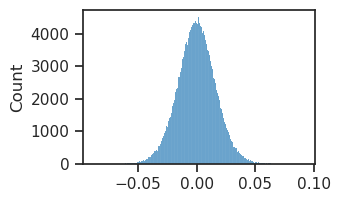

In [52]:
sns.histplot(tonp(output['recon']).ravel())

In [53]:
torch.linalg.norm(x - output['recon'])

tensor(16062.4199, device='cuda:1')

In [57]:
torch.linalg.vector_norm(x, dim=(1, 2, 3))

tensor([16.1712, 17.8204, 17.1546, 17.4887, 15.2351, 13.8046, 14.4861, 15.8304,
        16.8706, 15.9119, 16.0337, 17.5957, 15.5436, 15.5501, 17.2524, 13.9267,
        15.9448, 14.6113, 13.9136, 15.0035, 16.1887, 16.0327, 15.6600, 16.2003,
        13.5863, 16.0639, 16.3836, 17.4057, 16.6376, 15.4988, 15.7717, 18.1003,
        18.8305, 16.6373, 15.0859, 17.5090, 16.7667, 15.4574, 15.6380, 16.4670,
        12.9509, 15.8223, 16.5232, 18.2716, 19.5390, 17.7261, 16.3506, 17.1064,
        14.1249, 18.9495, 13.9955, 15.7458, 17.0579, 15.1183, 18.2510, 18.6029,
        15.4826, 16.4364, 17.6743, 15.5011, 17.6431, 18.0018, 15.5249, 16.6046,
        16.3705, 16.6085, 16.4423, 13.8570, 12.0226, 16.4765, 16.4173, 14.6010,
        17.2740, 14.8450, 16.5869, 10.1422, 15.0012, 16.5645, 15.3784, 16.3686,
        16.3181, 16.5328, 13.5699, 16.5193, 16.5986, 15.9727, 15.9985, 15.1858,
        17.3116, 11.9593, 16.0082, 13.5866, 15.1921, 15.3370, 13.0377, 16.6533,
        20.3516, 15.7366, 17.1255, 16.49